# Checkpoint 2: UNESCO Atlas of the World's Languages in Danger
<em>Vikram Ramavarapu</em>

For this checkpoint, we will investigate The United Nations Educational, Scientific and Cultural Organization's (UNESCO) Atlas of the World's Languages in Danger. This is a dataset containing languages that are severely decreasing in speakers. An example of one of these languages would be the Ainu language of Hokkaido, Japan which only has two reported speakers remaining. The question we intend to answer is which part of the world holds the most of these languages and why?

## Hypothesis

There a correlation between location and number of endangered languages. Due to colonialism and major cultural shifts, I expect to see more endangered languages in countries in Africa or South/Southeast Asia.

## Loading the Dataset

To avoid confounds, we will only select languages marked <em>Critically Endangered</em>.

In [1]:
%matplotlib inline
import pandas as pd
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import matplotlib.cm as cm

data = pd.read_excel('sources/unesco_atlas_languages_limited_dataset.xls')
data = data.loc[data['Degree of endangerment'] == 'Critically endangered']
print(data)

*** No CODEPAGE record, no encoding_override: will use 'iso-8859-1'
ERROR *** XF[17] unknown format key (2, 0x0002)
ERROR *** XF[18] unknown format key (1, 0x0001)
        ID Name in English Name in French Name in Spanish  \
1       78         'Ongota         ongota          birale   
6     2655           Abaga          abaga           abaga   
16     829        Achumawi       achumawi        achumawi   
26     144           Ahtna          ahtna            atna   
28     511           Aimol          aimol           aimol   
...    ...             ...            ...             ...   
2706  2180        Zenatiya       zenatiya        zenatiya   
2708  2177         Zidgali        zidgali         zidgali   
2712    45          Zumaya         zumaya          zumaya   
2716  1406          |Xaise         |xaise          |xaise   
2723  1401           ÇHoa          Çhoa      |hua-owani   

                     Countries Country codes alpha 3 ISO639-3 codes  \
1                     Ethiopia  

## Formatting the Data

Now we want to get a country heatmap of the number of endangered languages worldwide. First we must count and group by languages.

In [2]:
data = data.groupby(['Country codes alpha 3']).size()

''' 
Some entries in the xls will have languages that belong to multiple countries.
This means that the country code field will be formatted as such: ABC, XYZ

We must fix this by just splitting it into each country code so that a heatmap can be generated.
'''

for key in list(data.index):
    if ',' in key:
        # Split the key, and add to each country

        curr = key.split(', ')
        for country in curr:
            if country not in data.index:
                data[country] = data[key]
            else:
                data[country] += data[key]

# Drop each entry with comma separated countries
drops = []
for key in list(data.index):
    if ',' in key:
        drops.append(key)

data = data.drop(drops)

print(data)

Country codes alpha 3
AFG     2
ARG     2
AUS    42
BEN     1
BGR     1
       ..
VUT    22
ZAF     3
ZAI     2
IRQ     1
NOR     1
Length: 81, dtype: int64


## Generating the Heatmap

Now we will use Cartopy to take this formatted data and draw a heatmap.

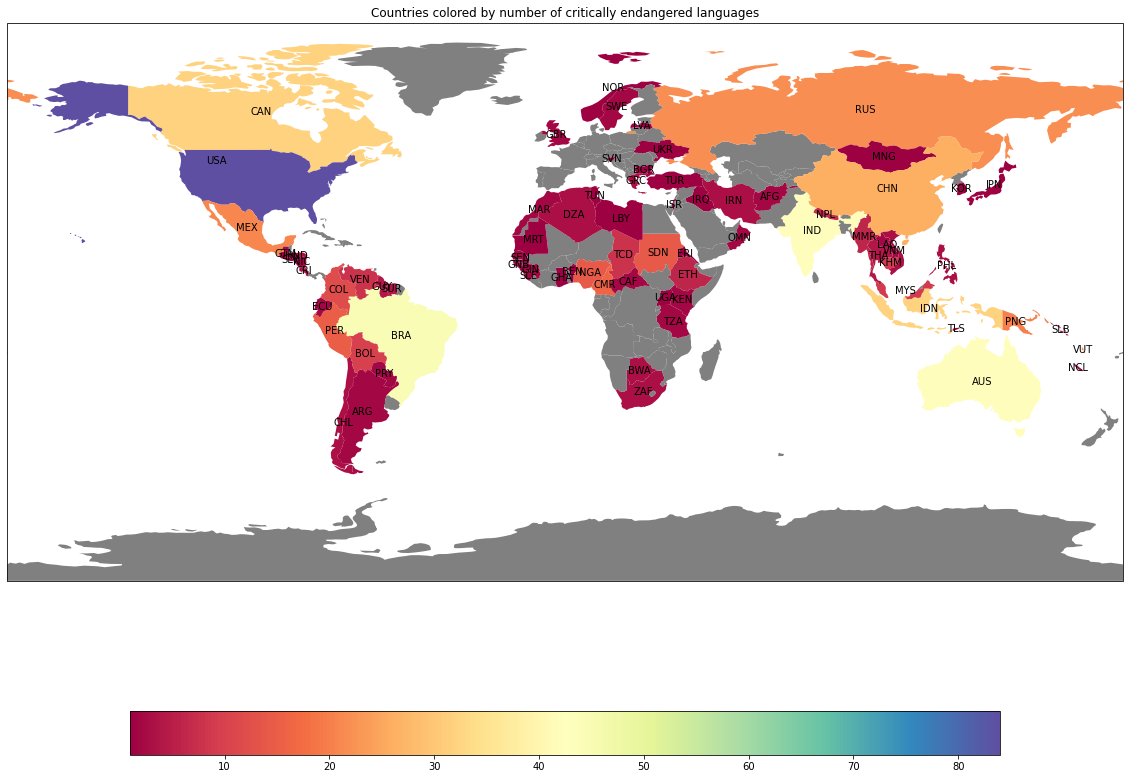

In [3]:
def colormap(mapname, vals, vmin=None, vmax=None):
    """ Creates some colormap related objects give the name of a colorm
    and an array `vals` of values that need to  be color mapped. """

    vmin = vmin if vmin else vals.min()
    vmax = vmax if vmax else vals.max()

    norms = Normalize(vmin, vmax, clip=True)
    cmap = cm.ScalarMappable(norm=norms, cmap=plt.get_cmap(mapname))
    *cvals, = map(cmap.to_rgba, vals)

    return cvals, cmap, norms

# Create color scheme for the map and convert it into a dictionary
*colormaps, = map(lambda x,y: colormap(x,y), ['Spectral'], [data.values])
color_dict = [dict(zip(data.index, cmap[0])) for cmap in colormaps]
color_dict = color_dict[0]

# Create the plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.figure.set_size_inches(20, 16)

# Load world map and extract data
shpfilename = shpreader.natural_earth(resolution='110m',
                                    category='cultural',
                                    name='admin_0_countries')
countries = shpreader.Reader(shpfilename).records()

ax.patch.set_visible(False)

for country in countries:
    # Get the country code for each country as that is recognized in the series
    country_code = country.attributes['GU_A3']
    try:
        # Add and color the country if possible
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=color_dict[country_code], label=country_code)
        cx, cy = country.geometry.centroid.x, country.geometry.centroid.y
        ax.text(cx, cy, country_code, ha='center', va='center', 
                transform=ccrs.PlateCarree())
    except:
        # Otherwise color it grey
        ax.add_geometries([country.geometry], ccrs.PlateCarree(), facecolor=(0.5, 0.5, 0.5, 1))

# Set title
ax.set_title('Countries colored by number of critically endangered languages')

# Create color bar
plt.colorbar(colormaps[0][1], ax=ax, orientation='horizontal', fraction=0.05, shrink=0.8)


## Analysis

Since African and Southeast asian countries are quite small, we can see that critically endangered languages are evenly spread across them, but per each country we see a very small of critically endangered languages.
  
The country with the most endangered languages appears to be USA. This could be due to more reporting from USA, and this could also be due to other factors such as the cultural change and movement within smaller ethnic communities in America.

Also as this is a limited dataset, we see a lot of grey area on the map.